# Parallel Molecular Docking


## Dependencies


In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import multiprocessing
from joblib import Parallel, delayed
import time
from typing import Dict, List, Tuple, Optional


## Parallel Docking Class


In [112]:
class CoarseDockingClass:
    def __init__(self, receptor_file: str, ligand_file: str):
        self.receptor_file = receptor_file
        self.ligand_file = ligand_file
        self.conformers = None
        self.energies = None
        self.rmsd_matrix = None
        self.n_jobs = multiprocessing.cpu_count()
        self.timings: Dict[str, float] = {}

    def setup(self) -> bool:
        """Load molecules."""
        start_time = time.time()
        try:
            self.receptor = Chem.MolFromPDBFile(self.receptor_file)
            if self.receptor is None:
                print("Failed to load receptor molecule")
                return False
            print(f"Receptor loaded successfully: {self.receptor.GetNumAtoms()} atoms")

            supplier = Chem.SDMolSupplier(self.ligand_file)
            self.ligand = next(supplier)
            if self.ligand is None:
                print("Failed to load ligand molecule")
                return False
            print(f"Ligand loaded successfully: {self.ligand.GetNumAtoms()} atoms")

            self.timings["setup"] = time.time() - start_time
            return True
        except Exception as e:
            print(f"Error in setup: {e}")
            return False

    def _process_conformer_batch(
        self, start_idx: int, n_conformers: int, total_conformers: int
    ) -> Tuple[List[float], np.ndarray]:
        """Process a batch of conformers including generation, optimization and RMSD calculation."""
        mol = Chem.AddHs(self.ligand)

        # Generate conformers for this batch
        params = AllChem.ETKDGv3()
        params.randomSeed = 42 + start_idx  # Different seed for each batch
        params.numThreads = 1  # Single thread per batch

        AllChem.EmbedMultipleConfs(mol, numConfs=n_conformers, params=params)

        # Optimize conformers
        energies = []
        for i in range(mol.GetNumConformers()):
            mp = AllChem.MMFFGetMoleculeProperties(mol)
            ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=i)
            ff.Minimize()
            energies.append(ff.CalcEnergy())

        # Calculate RMSD matrix for this batch
        rmsd_matrix = np.zeros((n_conformers, n_conformers))
        for i in range(n_conformers):
            for j in range(i + 1, n_conformers):
                rmsd = AllChem.GetConformerRMS(mol, i, j)
                rmsd_matrix[i, j] = rmsd
                rmsd_matrix[j, i] = rmsd

        return energies, rmsd_matrix

    def generate_conformers(
        self, n_conformers: int = 100, use_parallel: bool = True
    ) -> Tuple[Optional[List[float]], Optional[np.ndarray]]:
        """Generate conformers using coarse-grained parallelization."""
        start_time = time.time()
        print(f"\nGenerating {n_conformers} conformers...")

        try:
            if use_parallel and n_conformers >= self.n_jobs:
                print(
                    f"Using coarse-grained parallel processing with {self.n_jobs} cores..."
                )
                # Split conformers into batches
                batch_size = n_conformers // self.n_jobs
                batches = [
                    (
                        i * batch_size,
                        batch_size
                        if i < self.n_jobs - 1
                        else n_conformers - i * batch_size,
                    )
                    for i in range(self.n_jobs)
                ]

                # Process batches in parallel
                results = Parallel(n_jobs=self.n_jobs)(
                    delayed(self._process_conformer_batch)(
                        start_idx, size, n_conformers
                    )
                    for start_idx, size in batches
                )

                # Combine results
                self.energies = []
                self.rmsd_matrix = np.zeros((n_conformers, n_conformers))
                current_idx = 0
                for batch_energies, batch_rmsd in results:
                    batch_size = len(batch_energies)
                    self.energies.extend(batch_energies)
                    self.rmsd_matrix[
                        current_idx : current_idx + batch_size,
                        current_idx : current_idx + batch_size,
                    ] = batch_rmsd
                    current_idx += batch_size

            else:
                print("Using sequential processing...")
                energies, rmsd_matrix = self._process_conformer_batch(
                    0, n_conformers, n_conformers
                )
                self.energies = energies
                self.rmsd_matrix = rmsd_matrix

            self.timings["conformer_generation"] = time.time() - start_time
            return self.energies, self.rmsd_matrix

        except Exception as e:
            print(f"Error generating conformers: {e}")
            return None, None

## Results


In [113]:
def run_coarse_benchmark(
    receptor_file: str, ligand_file: str, n_conformers: int = 100
) -> Dict:
    """Run benchmark comparing coarse-grained parallel and sequential performance."""
    results = {"parallel": {"timings": {}}, "sequential": {"timings": {}}}

    # Run parallel version
    print("\nRunning parallel version...")
    parallel_docking = CoarseDockingClass(receptor_file, ligand_file)
    if parallel_docking.setup():
        parallel_docking.generate_conformers(
            n_conformers=n_conformers, use_parallel=True
        )
        results["parallel"]["timings"] = parallel_docking.timings.copy()

    # Run sequential version
    print("\nRunning sequential version...")
    sequential_docking = CoarseDockingClass(receptor_file, ligand_file)
    if sequential_docking.setup():
        sequential_docking.generate_conformers(
            n_conformers=n_conformers, use_parallel=False
        )
        results["sequential"]["timings"] = sequential_docking.timings.copy()

    return results

## Plot Performance Comparison



Running parallel version...
Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating 10 conformers...
Using coarse-grained parallel processing with 10 cores...

Running sequential version...
Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating 10 conformers...
Using sequential processing...

Running parallel version...
Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating 100 conformers...
Using coarse-grained parallel processing with 10 cores...

Running sequential version...
Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating 100 conformers...
Using sequential processing...

Running parallel version...
Receptor loaded successfully: 3180 atoms
Ligand loaded successfully: 20 atoms

Generating 500 conformers...
Using coarse-grained parallel processing with 10 cores...

Running sequential version...
Receptor loaded successfully: 3180 atoms
Ligan

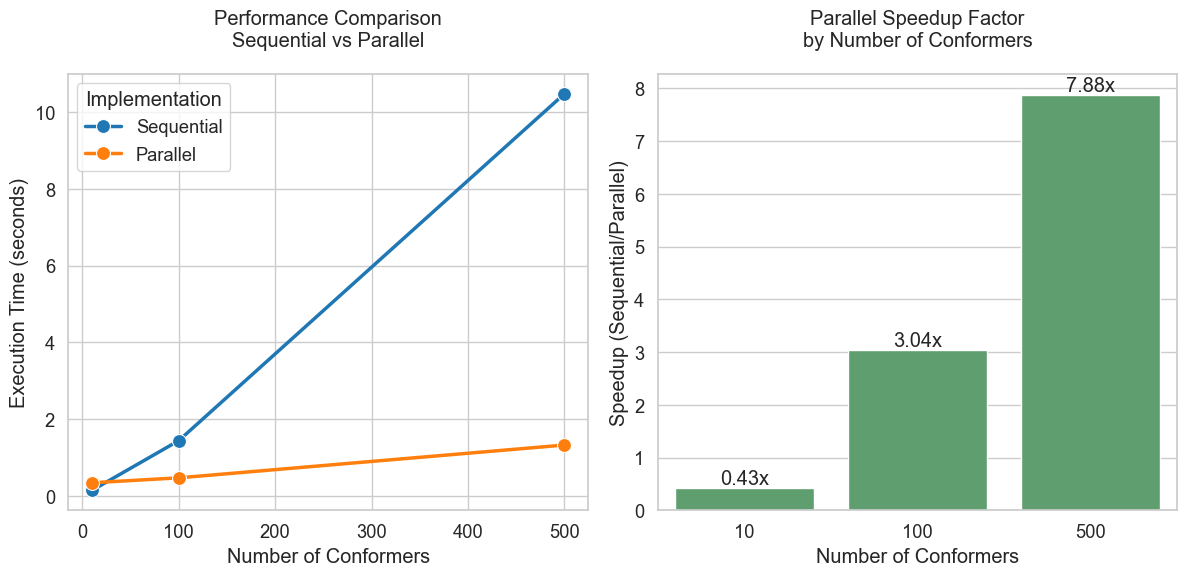

In [114]:
conformer_counts = [10, 100, 500]
benchmark_results = [
    run_coarse_benchmark(
        receptor_file="../data/Receptors/BACE1-2WJO.pdb",
        ligand_file="../data/Ligands/Baicalein-5281605.sdf",
        n_conformers=count,
    )
    for count in conformer_counts
]

sequential_times = [
    sum(result["sequential"]["timings"].values()) for result in benchmark_results
]
parallel_times = [
    sum(result["parallel"]["timings"].values()) for result in benchmark_results
]
speedups = [seq / par for seq, par in zip(sequential_times, parallel_times)]

performance_data = pd.DataFrame(
    {
        "Conformers": conformer_counts * 2,
        "Time (seconds)": sequential_times + parallel_times,
        "Implementation": ["Sequential"] * len(conformer_counts)
        + ["Parallel"] * len(conformer_counts),
    }
)

speedup_data = pd.DataFrame({"Conformers": conformer_counts, "Speedup": speedups})

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

fig = plt.figure(figsize=(18, 6))

# Performance Comparison Line Plot
plt.subplot(131)
sns.lineplot(
    data=performance_data,
    x="Conformers",
    y="Time (seconds)",
    hue="Implementation",
    marker="o",
    markersize=10,
    linewidth=2.5,
)
plt.title("Performance Comparison\nSequential vs Parallel", pad=20)
plt.xlabel("Number of Conformers")
plt.ylabel("Execution Time (seconds)")

# Speedup Bar Plot
plt.subplot(132)
sns.barplot(
    data=speedup_data, x="Conformers", y="Speedup", color=sns.color_palette("deep")[2]
)
plt.title("Parallel Speedup Factor\nby Number of Conformers", pad=20)
plt.xlabel("Number of Conformers")
plt.ylabel("Speedup (Sequential/Parallel)")
for i, speedup in enumerate(speedups):
    plt.text(i, speedup, f"{speedup:.2f}x", ha="center", va="bottom")

plt.tight_layout()
plt.show()